<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, Normalizer

from tensorflow.keras.datasets import boston_housing, mnist

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 

In [3]:
dataload = boston_housing.load_data(
    test_split=0.2,
    seed=734
)

(X_train, y_train), (X_test, y_test) = dataload

In [4]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


### Data Columns Description:

 - CRIM: per capita crime rate by town.
 - ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
 - INDUS: proportion of non-retail business acres per town. 
 - CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). 
 - NOX: nitric oxides concentration (parts per 10 million). 
 - RM: average number of rooms per dwelling. 
 - AGE: proportion of owner-occupied units built prior to 1940. 
 - DIS: weighted distances to ﬁve Boston employment centers. 
 - RAD: index of accessibility to radial highways. 
 - TAX: full-value property-tax rate per 10,000 dollars. 
 - PTRATIO: pupil-teacher ratio by town. 
 - B: 1000(Bk−0.63)^2 where Bk is the proportion of blacks by town. 
 - LSTAT: Percent lower status of the population. 
 - MEDV: Median value of owner-occupied homes in thousand dollars.

-----
- Normalize the data (all features should have roughly the same scale)

In [6]:
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
scaled_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.002685,0.000000,0.346041,0.0,0.321577,0.425560,0.708548,0.263902,0.130435,0.223282,0.617021,1.000000,0.392108
1,0.008951,0.000000,0.281525,0.0,0.309129,0.363096,0.347065,0.242514,0.130435,0.229008,0.893617,0.726325,0.274834
2,0.089763,0.000000,0.646628,0.0,0.645228,0.375359,1.000000,0.036692,1.000000,0.914122,0.808511,1.000000,0.629967
3,0.001142,0.000000,0.296921,0.0,0.271784,0.504694,0.530381,0.149879,0.173913,0.375954,0.882979,0.991352,0.310982
4,0.000853,0.231579,0.197947,0.0,0.087137,0.650699,0.040165,0.707208,0.260870,0.272901,0.691489,0.972584,0.049669


In [8]:
scaled_test_df = pd.DataFrame(scaler.transform(X_test), columns=cols)
scaled_test_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.026552,0.000000,0.700880,0.0,1.000000,0.261544,0.955716,0.030118,0.173913,0.412214,0.223404,0.986837,0.767108
1,0.002892,0.000000,0.296921,0.0,0.271784,0.511209,0.909372,0.128718,0.173913,0.375954,0.882979,0.985620,0.381347
2,0.001053,0.357895,0.206378,0.0,0.091286,0.655490,0.152420,0.396666,0.260870,0.270992,0.372340,0.983591,0.086369
3,0.004448,0.000000,0.346041,0.0,0.321577,0.540525,0.662204,0.218507,0.130435,0.223282,0.617021,0.995714,0.238135
4,0.000531,0.221053,0.189883,0.0,0.103734,0.565242,0.187436,0.516973,0.130435,0.106870,0.446809,1.000000,0.097958


-----
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.metrics import mae


bh_model = Sequential(name='sandboxModeling')

bh_model.add(Dense(13, input_dim=13, activation='relu', name='Dense1'))
bh_model.add(Dense(8, activation='tanh', name='Dense2'))
bh_model.add(Dropout(0.15, name="Dropout1"))
bh_model.add(Dense(8, activation='tanh', name='Dense3'))
bh_model.add(Dropout(0.15, name="Dropout2"))

bh_model.add(Dense(1, activation='relu', name='Dense4'))


bh_model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mae'])
bh_model.summary()

Model: "sandboxModeling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 13)                182       
_________________________________________________________________
Dense2 (Dense)               (None, 8)                 112       
_________________________________________________________________
Dropout1 (Dropout)           (None, 8)                 0         
_________________________________________________________________
Dense3 (Dense)               (None, 8)                 72        
_________________________________________________________________
Dropout2 (Dropout)           (None, 8)                 0         
_________________________________________________________________
Dense4 (Dense)               (None, 1)                 9         
Total params: 375
Trainable params: 375
Non-trainable params: 0
_____________________________________________________

- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [51]:
bh_model.fit(X_train, y_train, epochs=1000)

 111us/sample - loss: 44.5410 - mean_absolute_error: 4.5955
Epoch 835/1000
404/404 [==============================] - 0s 114us/sample - loss: 40.1932 - mean_absolute_error: 4.4629
Epoch 836/1000
404/404 [==============================] - 0s 94us/sample - loss: 45.2569 - mean_absolute_error: 4.6758
Epoch 837/1000
404/404 [==============================] - 0s 111us/sample - loss: 42.5781 - mean_absolute_error: 4.6676
Epoch 838/1000
404/404 [==============================] - 0s 109us/sample - loss: 42.5491 - mean_absolute_error: 4.6160
Epoch 839/1000
404/404 [==============================] - 0s 101us/sample - loss: 44.7010 - mean_absolute_error: 4.7497
Epoch 840/1000
404/404 [==============================] - 0s 104us/sample - loss: 46.4882 - mean_absolute_error: 4.8347
Epoch 841/1000
404/404 [==============================] - 0s 102us/sample - loss: 43.0399 - mean_absolute_error: 4.6228
Epoch 842/1000
404/404 [==============================] - 0s 101us/sample - loss: 45.2608 - mean_abso

In [38]:
bh_model.evaluate(X_train, y_train)

404/404 [==============================] - 0s 223us/sample - loss: 67.7098 - mean_absolute_error: 6.0033


[67.70983894272607, 6.0032506]

In [39]:
bh_model.evaluate(X_test, y_test)

102/102 [==============================] - 0s 69us/sample - loss: 74.1867 - mean_absolute_error: 6.3682


[74.18674252079983, 6.36815]

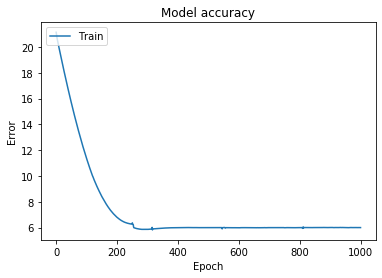

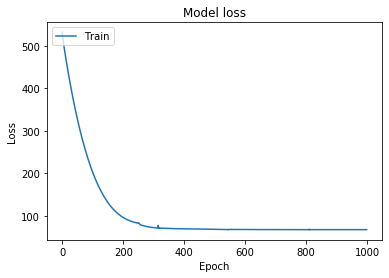

In [40]:
import matplotlib.pyplot as plt

histplot = bh_model.history

# Plot training & validation accuracy values
plt.plot(histplot.history['mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(histplot.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
bh_model2 = Sequential(name='sandboxModeling2')

bh_model2.add(Dense(13, input_dim=13, activation='relu', name='Dense1'))
bh_model2.add(Dense(8, activation='tanh', name='Dense2'))
# bh_model2.add(Dense(8, activation='tanh', name='Dense3'))
bh_model2.add(Dense(1, activation='relu', name='Dense4'))

bh_model2.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mae'])

bh_model2.summary()

Model: "sandboxModeling2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 13)                182       
_________________________________________________________________
Dense2 (Dense)               (None, 8)                 112       
_________________________________________________________________
Dense4 (Dense)               (None, 1)                 9         
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [25]:
bh_model2.fit(X_train, y_train, epochs=1000)

- mean_absolute_error: 5.2804
Epoch 834/1000
404/404 [==============================] - 0s 62us/sample - loss: 57.8463 - mean_absolute_error: 5.3294
Epoch 835/1000
404/404 [==============================] - 0s 54us/sample - loss: 56.4658 - mean_absolute_error: 5.2140
Epoch 836/1000
404/404 [==============================] - 0s 64us/sample - loss: 56.1408 - mean_absolute_error: 5.1758
Epoch 837/1000
404/404 [==============================] - 0s 54us/sample - loss: 55.8784 - mean_absolute_error: 5.1575
Epoch 838/1000
404/404 [==============================] - 0s 62us/sample - loss: 56.5147 - mean_absolute_error: 5.2244
Epoch 839/1000
404/404 [==============================] - 0s 59us/sample - loss: 56.3118 - mean_absolute_error: 5.1915
Epoch 840/1000
404/404 [==============================] - 0s 67us/sample - loss: 55.8680 - mean_absolute_error: 5.1632
Epoch 841/1000
404/404 [==============================] - 0s 62us/sample - loss: 56.0900 - mean_absolute_error: 5.1887
Epoch 842/1000
404

In [26]:
bh_model2.evaluate(X_train, y_train)
bh_model2.evaluate(X_test, y_test)

102/102 [==============================] - 0s 88us/sample - loss: 38.0722 - mean_absolute_error: 4.2977


[38.07223024555281, 4.2976747]

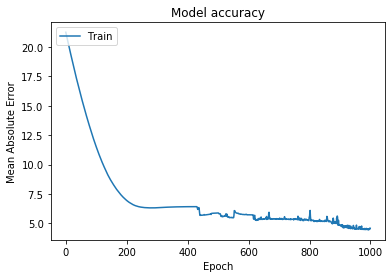

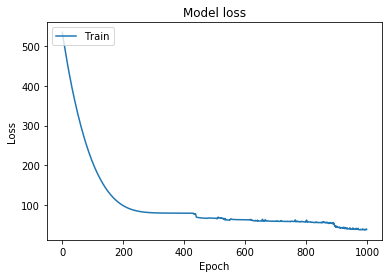

In [28]:
histplot2 = bh_model2.history

# Plot training & validation accuracy values
plt.plot(histplot2.history['mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(histplot2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.

In [58]:
(X_train2, y_train2), (X_test2, y_test2) = mnist.load_data()
print(X_train2.shape, y_train2.shape)

(60000, 28, 28) (60000,)


In [60]:
X_train2[0].shape

(28, 28)

In [107]:
X_train2[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [67]:
28*28

784

In [68]:
X_train2 = X_train2.reshape(60000, 784)
X_test2 = X_test2.reshape(10000, 784)

In [70]:
X_train2 = X_train2.astype('float32')
X_test2 = X_test2.astype('float32')

In [81]:
print(y_train2)

[5 0 4 ... 5 6 8]


In [82]:
np.unique(y_train2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [83]:
from tensorflow.keras.utils import to_categorical

In [84]:
y_train2 = to_categorical(y_train2, num_classes=10)
y_test2 = to_categorical(y_test2, num_classes=10)

In [85]:
y_train2[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [86]:
mnist_model = Sequential(name='mnistModeling')

mnist_model.add(Dense(16, input_dim=784, activation='relu', name='Dense1'))
mnist_model.add(Dense(8, activation='relu', name='Dense2'))
mnist_model.add(Dropout(0.15, name="Dropout1"))
mnist_model.add(Dense(8, activation='relu', name='Dense3'))
mnist_model.add(Dropout(0.15, name="Dropout2"))

mnist_model.add(Dense(10, activation='softmax', name='Output'))


mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mnist_model.summary()

Model: "mnistModeling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 16)                12560     
_________________________________________________________________
Dense2 (Dense)               (None, 8)                 136       
_________________________________________________________________
Dropout1 (Dropout)           (None, 8)                 0         
_________________________________________________________________
Dense3 (Dense)               (None, 8)                 72        
_________________________________________________________________
Dropout2 (Dropout)           (None, 8)                 0         
_________________________________________________________________
Output (Dense)               (None, 10)                90        
Total params: 12,858
Trainable params: 12,858
Non-trainable params: 0
_________________________________________________

In [87]:
mnist_model.fit(X_train2, y_train2, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 4s 61us/sample - loss: 2.2995 - acc: 0.1954
Epoch 2/100
60000/60000 [==============================] - 4s 60us/sample - loss: 1.5964 - acc: 0.3949
Epoch 3/100
60000/60000 [==============================] - 3s 58us/sample - loss: 1.3190 - acc: 0.5459
Epoch 4/100
60000/60000 [==============================] - 4s 58us/sample - loss: 1.1043 - acc: 0.6375
Epoch 5/100
60000/60000 [==============================] - 3s 57us/sample - loss: 0.9877 - acc: 0.6689
Epoch 6/100
60000/60000 [==============================] - 4s 63us/sample - loss: 0.9082 - acc: 0.6986
Epoch 7/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.8604 - acc: 0.7194
Epoch 8/100
60000/60000 [==============================] - 4s 59us/sample - loss: 0.8127 - acc: 0.7425
Epoch 9/100
60000/60000 [==============================] - 3s 57us/sample - loss: 0.7758 - acc: 0.7569
Epoch 10/100
60000/60000 [==============================] - 4s 58us/sampl

In [89]:
scores = mnist_model.evaluate(X_test2, y_test2)
print(f'{mnist_model.metrics_names[1]}: {scores[1]*100}')

10000/10000 [==============================] - 0s 43us/sample - loss: 0.5311 - acc: 0.8900
acc: 88.99999856948853


-----
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

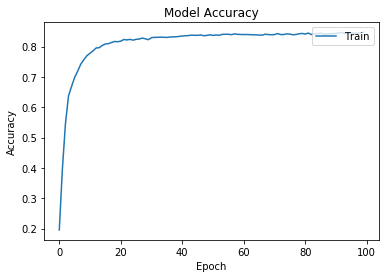

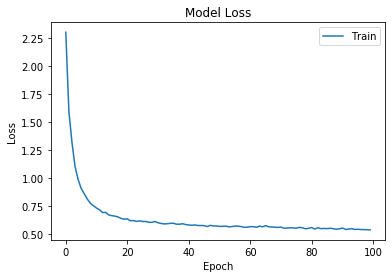

In [93]:
mnist_hist = mnist_model.history

# Plot training & validation accuracy values
plt.plot(mnist_hist.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(mnist_hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


### Data Exploration
after the fact, but nonetheless

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.